In [1]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# data
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)

# misc
import datetime
from typing import Tuple
from tqdm import tqdm

# utility  imports
from utilities.processing_utility import get_q_2_cw_data, get_train_test_split
from utilities.plotting_utility import plot_daily, plot_price_and_returns
from utilities.strategy_utilities import get_theta_and_V, get_turnover_dollars, get_turnover_units
from utilities.performance_utilities import *

# strategies imports
import strategies.gp_mean_reversion as gp_mean_reversion
from strategies.gp_mean_reversion import get_gp_mean_reversion_signal
import strategies.gp_prediction as gp_prediction
from strategies.gp_prediction import get_augmented_data, get_gp_prediction_signal


In [2]:
df = get_q_2_cw_data()
df.to_csv('cw_2_data.csv')

[*********************100%***********************]  1 of 1 completed


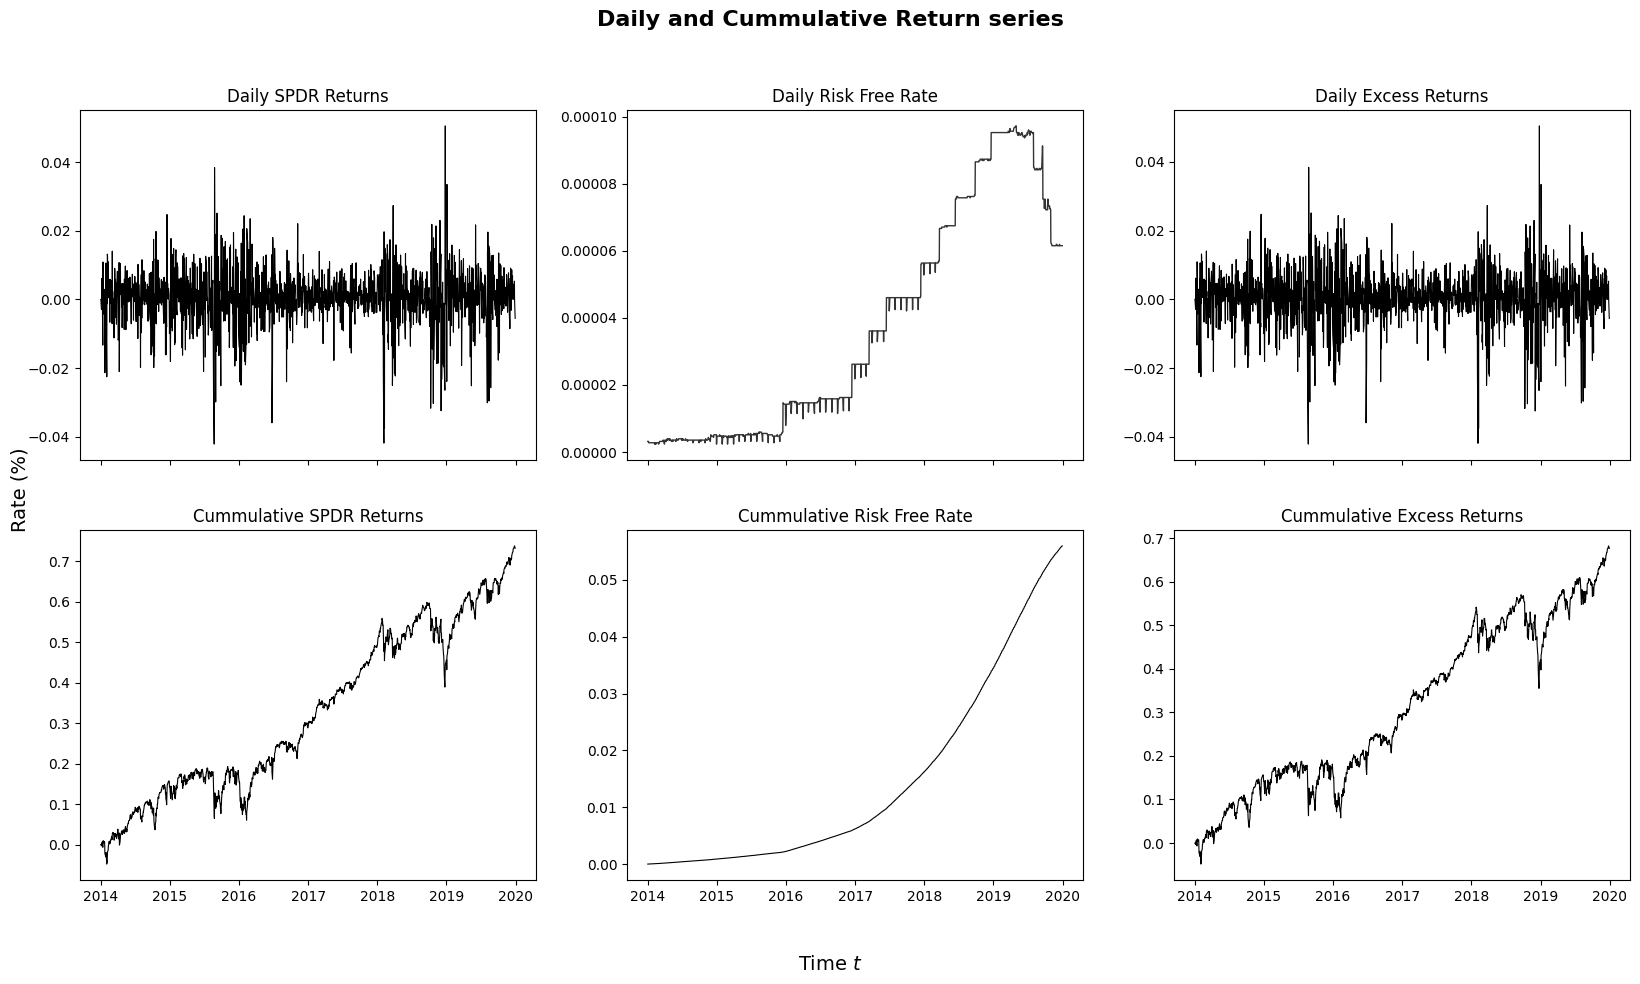

In [3]:
daily_returns_fig = plot_daily(df)

# save figure
daily_returns_fig.savefig('figures/01_daily_returns.png')

In [4]:
# get train test split
split_idx = int(len(df) * 0.7)
risk_free_rate_series = torch.tensor(df['daily_effr'].to_numpy(), dtype=torch.float32)
excess_return_data = torch.tensor(df['daily_excess_returns'].to_numpy(), dtype=torch.float32)
norm_excess_return_data = torch.tensor(df['normalised_excess_returns'].to_numpy(), dtype=torch.float32)
price_data = torch.tensor(df['adjusted_close_price'].to_numpy(), dtype=torch.float32)
x_data = torch.arange(0, len(price_data), dtype=torch.float32)

train_data, test_data = get_train_test_split(splitindex = split_idx, RFR = risk_free_rate_series, daily_R = excess_return_data, norm_R = norm_excess_return_data, P = price_data, X = x_data)

rfr_train, rfr_test = train_data['RFR'], test_data['RFR'] #  risk free rate
daily_r_train, daily_r_test = train_data['daily_R'], test_data['daily_R'] # daily excess returns
norm_r_train, norm_r_test = train_data['norm_R'], test_data['norm_R'] # normalised daily excess returns
p_train, p_test = train_data['P'], test_data['P'] # adjusted closing price
x_train, x_test = train_data['X'], test_data['X'] # x data


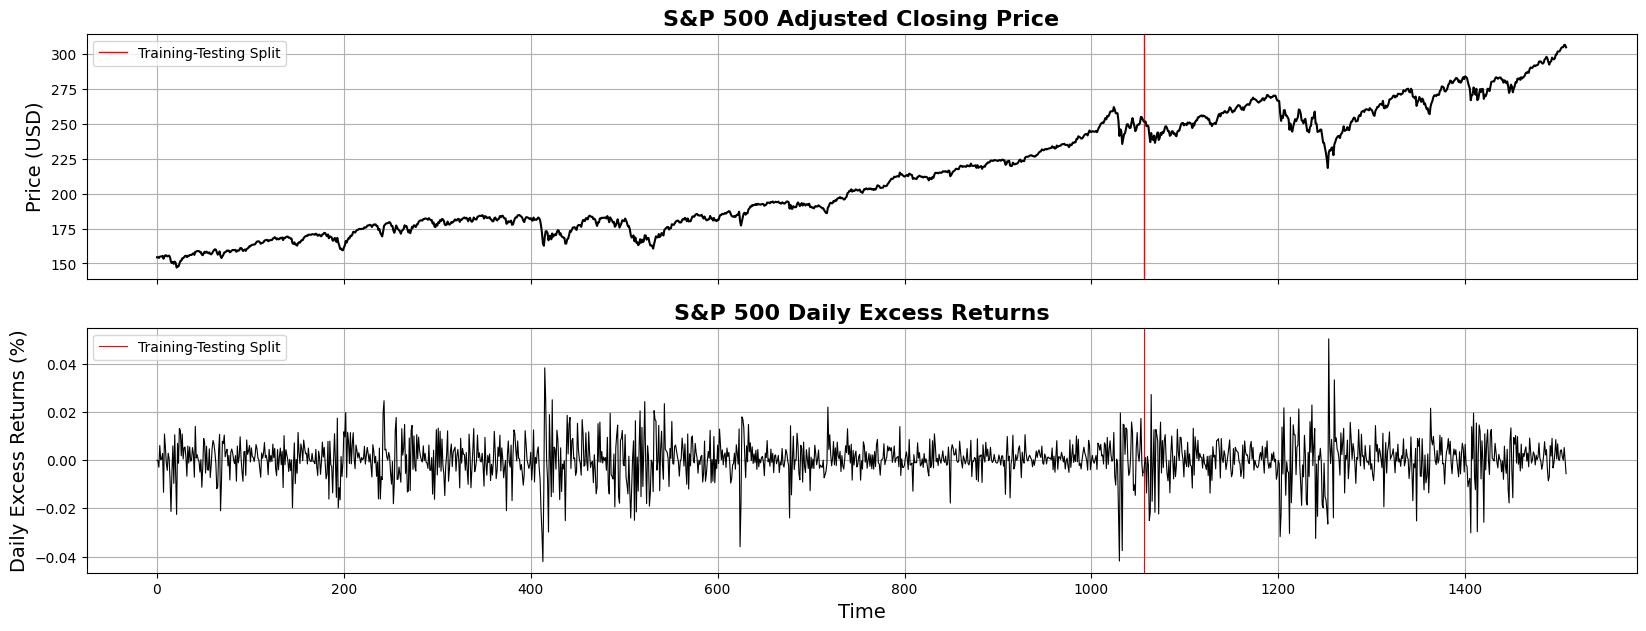

In [5]:
price_and_returns_fid = plot_price_and_returns(x_train, p_train, daily_r_train, x_test, p_test, daily_r_test)

# save figure
price_and_returns_fid.savefig('figures/02_price_and_returns_train_test_split.png')

In [6]:
# LONG ONLY 
train_lo_s = torch.ones_like(p_train)
test_lo_s = torch.ones_like(p_test)

In [7]:
# optimise the GP train signal
_, mr_noise_hat = gp_mean_reversion.optimise_marginal_likelihood(inputs=x_train, targets=norm_r_train, n_iter = 100)

       Iteration        |          Loss          |      Lengthscale       |         Noise          
           10           |   1.3991682529449463   |        0.64960         |        0.64959         
----------------------------------------------------------------------------------------------------
           20           |   1.3906853199005127   |        0.60323         |        0.60455         
----------------------------------------------------------------------------------------------------
           30           |   1.3829541206359863   |        0.56091         |        0.56360         
----------------------------------------------------------------------------------------------------
           40           |   1.3761731386184692   |        0.52250         |        0.52931         
----------------------------------------------------------------------------------------------------
           50           |   1.3732050657272339   |        0.48914         |        0.50181      

In [8]:
# MEAN REVERSION SIGNAL - GAUSSIAN PROCESS
train_gpmr_s, train_gpmr_bm, train_gpmr_sm = get_gp_mean_reversion_signal(x_train, norm_r_train, lengthscale=2.5, noise=mr_noise_hat)
test_gpmr_s, test_gpmr_bm, test_gpmr_sm = get_gp_mean_reversion_signal(x_test, norm_r_test, lengthscale=2.5, noise=mr_noise_hat)

/Users/maxnorman/UCL/term_2/comp0051_algorithmic_trading/comp0051_env/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/bd/shyl3h_n5bq3xz2xw1yv1jnm0000gp/T/ipykernel_18980/1196582096.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(x_test, f_preds.mean.detach().numpy(), 'b', lw = 1, color = 'steelblue', label = 'GP Mean')


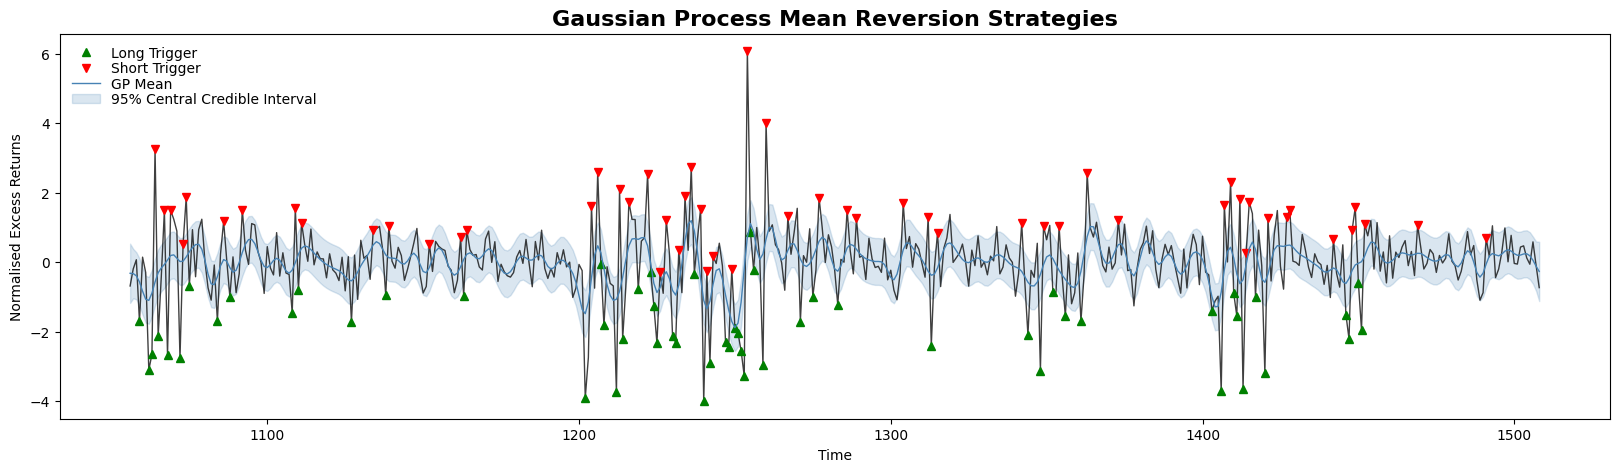

In [9]:
plt.plot(x_test, norm_r_test, 'black', lw = 1, alpha = .75)
plt.plot(x_test[test_gpmr_bm == 1.], norm_r_test[test_gpmr_bm == 1], 'g^', label = 'Long Trigger')
plt.plot(x_test[test_gpmr_sm == 1], norm_r_test[test_gpmr_sm == 1], 'rv', label = 'Short Trigger')
plt.xlabel('Time')
plt.ylabel('Normalised Excess Returns')

# plot GP
constant_gp = gp_mean_reversion.get_constant_gp(x_train=x_test, y_train=norm_r_test, length_scale=2.5, noise=mr_noise_hat)
f_preds = gp_mean_reversion.get_gp_posterior(constant_gp, x_test)
lower, upper = f_preds.confidence_region()
plt.plot(x_test, f_preds.mean.detach().numpy(), 'b', lw = 1, color = 'steelblue', label = 'GP Mean')
plt.fill_between(x_test, lower.detach().numpy(), upper.detach().numpy(),color = 'steelblue', alpha=0.2, label = '95% Central Credible Interval')
plt.legend(labelspacing=0.1, loc='upper left', frameon=False)

plt.title('Gaussian Process Mean Reversion Strategies', fontsize=16, fontweight='bold')

# save figure
plt.savefig('figures/03_mean_reversion_strategies.png')

In [10]:
# GAUSSIAN PROCESS PREDICTION
train_data = get_augmented_data(x_train, p_train)
test_data = get_augmented_data(x_test, p_test)

In [11]:
gp_pred_lengthscale_hat, gp_pred_noise_hat = gp_prediction.optimise_marginal_likelihood(train_data, p_train, 1000)

       Iteration        |          Loss          |      Lengthscale       |         Noise          
          100           |   693.1820068359375    |        5.68896         |        2.98013         
----------------------------------------------------------------------------------------------------
          200           |   392.0276184082031    |        7.64668         |        3.27381         
----------------------------------------------------------------------------------------------------
          300           |   277.7356872558594    |        9.01560         |        3.45654         
----------------------------------------------------------------------------------------------------
          400           |   216.3287353515625    |        10.10888        |        3.59468         
----------------------------------------------------------------------------------------------------
          500           |   177.6165771484375    |        11.03584        |        3.70839      

In [12]:
# GAUSSIAN PROCESS PREDICTION SIGNAL
train_gp_pred_s, train_gp_pred_bm, train_gp_predo_sm = get_gp_prediction_signal(train_data, p_train, lengthscale=12, noise=5, window=80)
test_gp_pred_s, test_gp_pred_bm, test_gp_pred_sm = get_gp_prediction_signal(test_data, p_test, lengthscale=12, noise=5, window=80)

/Users/maxnorman/UCL/term_2/comp0051_algorithmic_trading/comp0051_env/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/bd/shyl3h_n5bq3xz2xw1yv1jnm0000gp/T/ipykernel_18980/977298389.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax1.plot(x_test, f_preds.mean.detach().numpy(), 'b', lw = 1, color = 'steelblue', label = 'GP Mean')


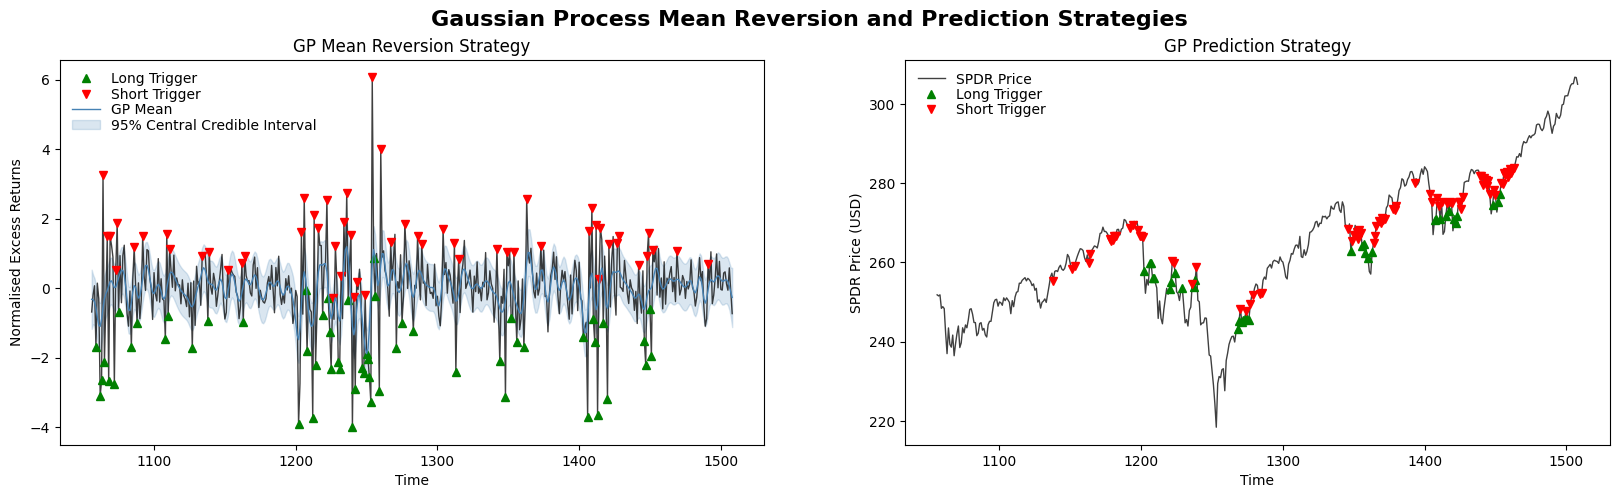

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(x_test, norm_r_test, 'black', lw = 1, alpha = .75)
ax1.plot(x_test[test_gpmr_bm == 1.], norm_r_test[test_gpmr_bm == 1], 'g^', label = 'Long Trigger')
ax1.plot(x_test[test_gpmr_sm == 1], norm_r_test[test_gpmr_sm == 1], 'rv', label = 'Short Trigger')
ax1.set_xlabel('Time')
ax1.set_ylabel('Normalised Excess Returns')

# plot GP
constant_gp = gp_mean_reversion.get_constant_gp(x_train=x_test, y_train=norm_r_test, length_scale=2.5, noise=mr_noise_hat)
f_preds = gp_mean_reversion.get_gp_posterior(constant_gp, x_test)
lower, upper = f_preds.confidence_region()
ax1.plot(x_test, f_preds.mean.detach().numpy(), 'b', lw = 1, color = 'steelblue', label = 'GP Mean')
ax1.fill_between(x_test, lower.detach().numpy(), upper.detach().numpy(),color = 'steelblue', alpha=0.2, label = '95% Central Credible Interval')
ax1.legend(labelspacing=0.1, loc='upper left', frameon=False)

ax2.plot(x_test, p_test, 'black', lw = 1, alpha = .75, label = 'SPDR Price')
ax2.plot(x_test[test_gp_pred_bm == 1.], p_test[test_gp_pred_bm == 1], 'g^', label = 'Long Trigger')
ax2.plot(x_test[test_gp_pred_sm == 1], p_test[test_gp_pred_sm == 1], 'rv', label = 'Short Trigger')
ax2.set_xlabel('Time')
ax2.set_ylabel('SPDR Price (USD)')
ax2.legend(labelspacing=0.1, loc='upper left', frameon=False)
plt.suptitle('Gaussian Process Mean Reversion and Prediction Strategies', fontsize=16, fontweight='bold')

ax1.set_title('GP Mean Reversion Strategy')
ax2.set_title('GP Prediction Strategy')


# save figure
plt.savefig('figures/000_mean_reversion_and_prediction_strategies.png')

In [14]:
# GET LONG ONLY V
train_lo_strat = get_theta_and_V(daily_r_train, rfr_train , train_lo_s, initial_cash = 200_000., leverage = 5.)
test_lo_strat = get_theta_and_V(daily_r_test, rfr_test , test_lo_s, initial_cash = 200_000., leverage = 5.)

# # GET MEAN REVERSION - GAUSSIAN PROCESS
train_gpmr_strat = get_theta_and_V(daily_r_train, rfr_train , train_gpmr_s, initial_cash = 200_000., leverage = 5.)
test_gpmr_strat = get_theta_and_V(daily_r_test, rfr_test , test_gpmr_s, initial_cash = 200_000., leverage = 5.)

# GET PREDICTION - GAUSSIAN PROCESS
train_gp_pred_strat = get_theta_and_V(daily_r_train, rfr_train , train_gp_pred_s, initial_cash = 200_000., leverage = 5.)
test_gp_pred_strat = get_theta_and_V(daily_r_test, rfr_test , test_gp_pred_s, initial_cash = 200_000., leverage = 5.)

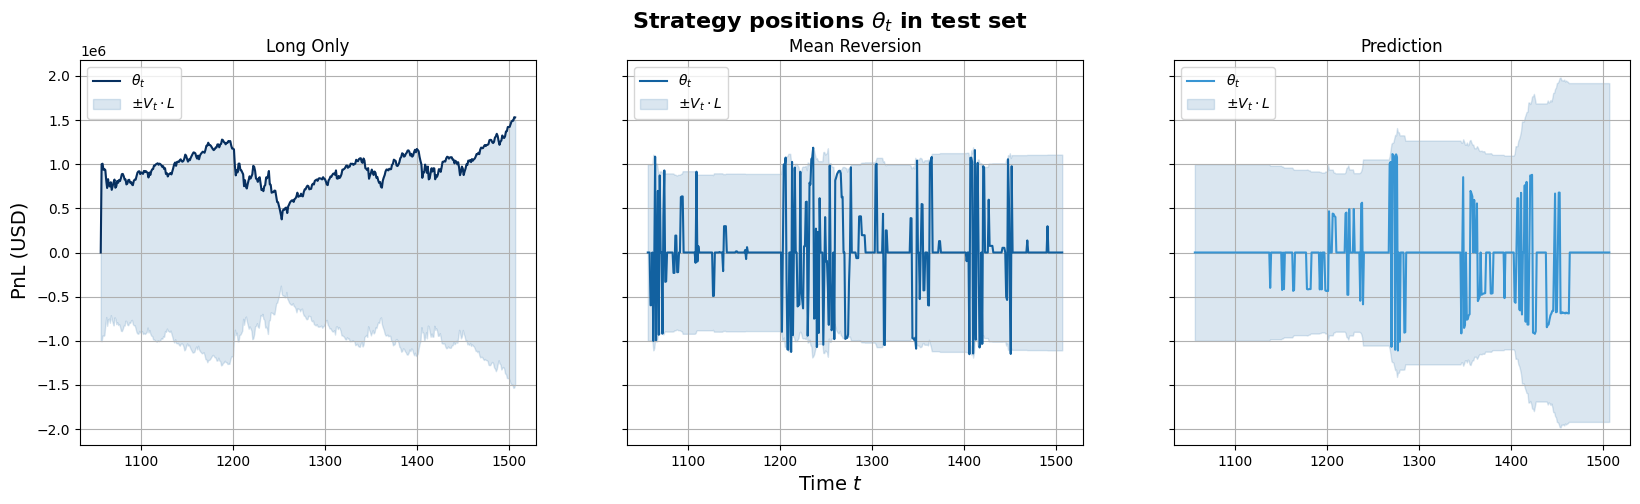

In [15]:
palette = ["#072F5F", "#1261A0", "#3895D3", "#58CCED"]

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 5), sharex=False, sharey=True)
L = 5

ax1.plot(x_test[:-1], test_lo_strat['theta'][:-1], color = '#072F5F', label = r'$\theta_t$')
ax1.fill_between(x_test[:-1], L*test_lo_strat['V_t'][:-1], -L*test_lo_strat['V_t'][:-1], alpha=0.2, color = 'steelblue', label = r'$\pm V_t \cdot L$')
ax1.grid(True)
ax1.legend(loc='upper left', frameon=True)
ax1.set_title('Long Only')

ax2.plot(x_test[:-1], test_gpmr_strat['theta'][:-1], color = '#1261A0', label = r'$\theta_t$')
ax2.fill_between(x_test[:-1], L*test_gpmr_strat['V_t'][:-1], -L*test_gpmr_strat['V_t'][:-1], alpha=0.2, color = 'steelblue', label = r'$\pm V_t \cdot L$')
ax2.grid(True)
ax2.legend(loc='upper left', frameon=True)
ax2.set_title('Mean Reversion')

ax3.plot(x_test[:-1], test_gp_pred_strat['theta'][:-1], color = '#3895D3', label = r'$\theta_t$')
ax3.fill_between(x_test[:-1], L*test_gp_pred_strat['V_t'][:-1], -L*test_gp_pred_strat['V_t'][:-1], alpha=0.2, color = 'steelblue', label = r'$\pm V_t \cdot L$')
ax3.grid(True)
ax3.legend(loc='upper left', frameon=True)
ax3.set_title('Prediction')

plt.suptitle(r'Strategy positions $\theta_t$ in test set', fontsize=16, fontweight='bold')

fig.text(0.5, 0.02, r'Time $t$', ha='center', fontsize=14)
fig.text(0.09, 0.5, 'PnL (USD)', va='center', rotation='vertical', fontsize=14)

plt.savefig('figures/04_strategy_positions.png')

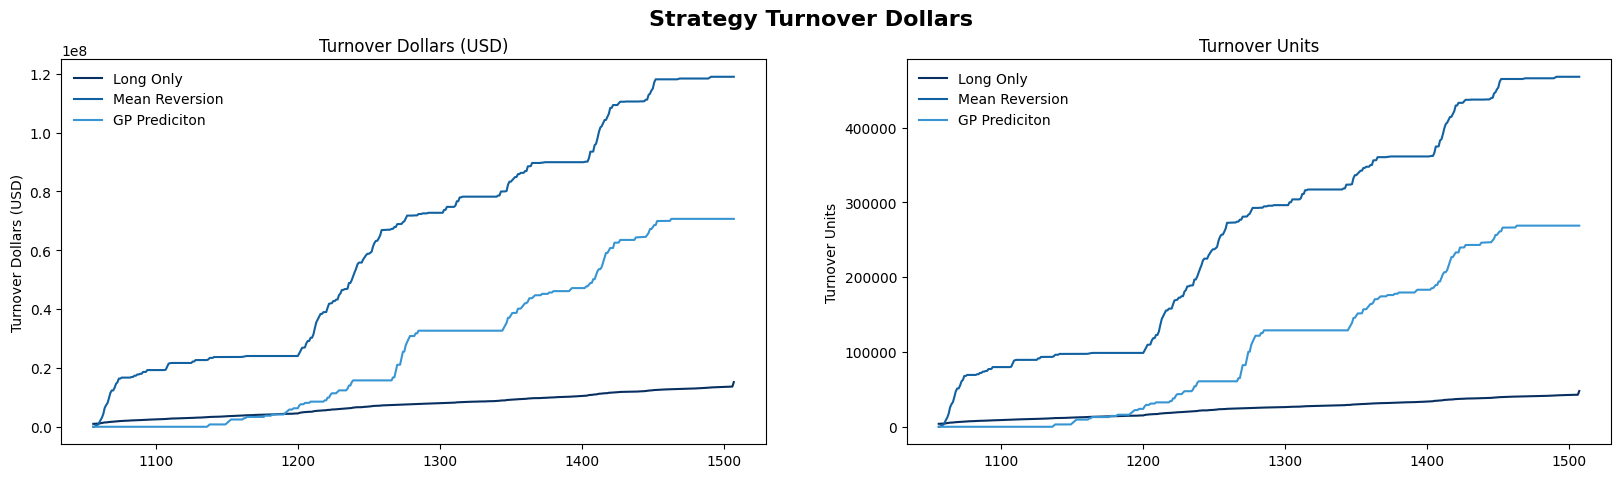

In [16]:
test_lo_turnover_units = np.cumsum(np.abs(np.diff(test_lo_strat['theta'] / p_test)))
test_gpmr_turnover_units = np.cumsum(np.abs(np.diff(test_gpmr_strat['theta'] / p_test)))
test_gp_pred_turnover_units = np.cumsum(np.abs(np.diff(test_gp_pred_strat['theta'] / p_test)))

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 5), sharex=False, sharey=False)

ax1.plot(x_test[:-1], np.cumsum(np.abs(np.diff(test_lo_strat['theta']))), color = '#072F5F', label = r'Long Only')
ax1.plot(x_test[:-1], np.cumsum(np.abs(np.diff(test_gpmr_strat['theta']))), color = '#1261A0', label = r'Mean Reversion')
ax1.plot(x_test[:-1], np.cumsum(np.abs(np.diff(test_gp_pred_strat['theta']))), color = '#3895D3', label = r'GP Prediciton')
ax1.legend(loc='upper left', frameon=False)
ax1.set_title('Turnover Dollars (USD)')
ax1.set_ylabel('Turnover Dollars (USD)')

ax2.plot(x_test[:-1], test_lo_turnover_units, color = '#072F5F', label = r'Long Only')
ax2.plot(x_test[:-1], test_gpmr_turnover_units, color = '#1261A0', label = r'Mean Reversion')
ax2.plot(x_test[:-1], test_gp_pred_turnover_units, color = '#3895D3', label = r'GP Prediciton')
ax2.legend(loc='upper left', frameon=False)
ax2.set_title('Turnover Units')
ax2.set_ylabel('Turnover Units')

plt.suptitle(r'Strategy Turnover Dollars', fontsize=16, fontweight='bold')

# save figure
plt.savefig('figures/04b_strategy_turnover.png')

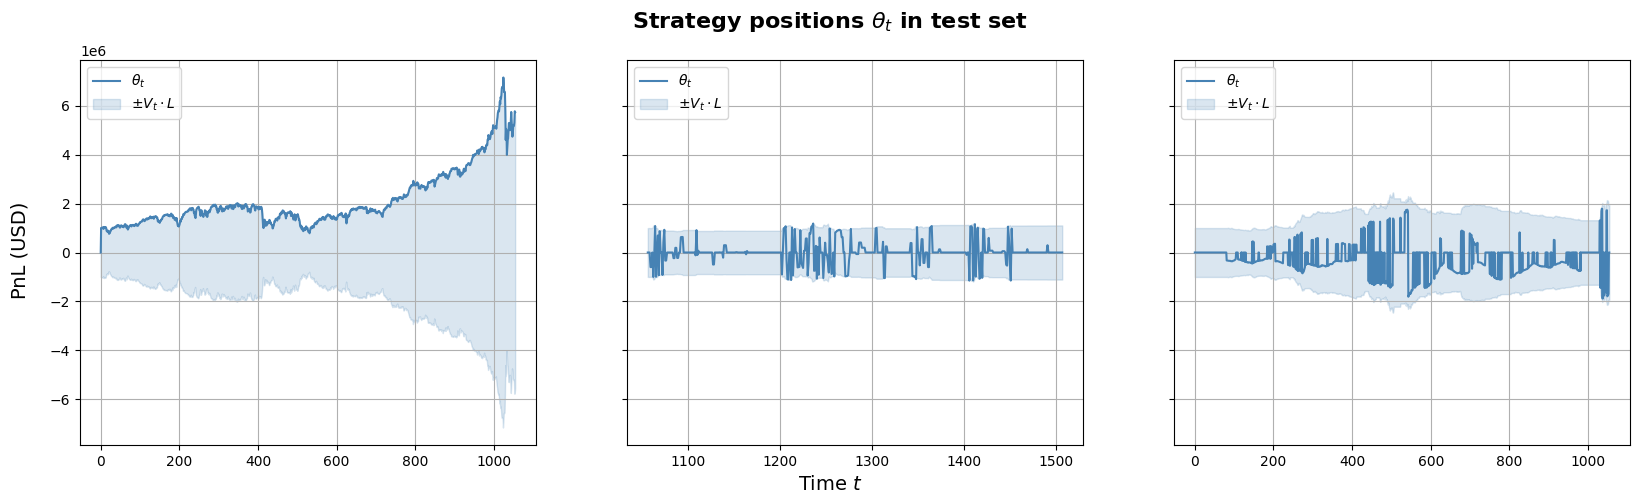

In [17]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 5), sharex=False, sharey=True)
L = 5

ax1.plot(x_train[:-1], train_lo_strat['theta'][:-1], color = 'steelblue', label = r'$\theta_t$')
ax1.fill_between(x_train[:-1], L*train_lo_strat['V_t'][:-1], -L*train_lo_strat['V_t'][:-1], alpha=0.2, color = 'steelblue', label = r'$\pm V_t \cdot L$')
ax1.grid(True)
ax1.legend(loc='upper left', frameon=True)

ax2.plot(x_test[:-1], test_gpmr_strat['theta'][:-1], color = 'steelblue', label = r'$\theta_t$')
ax2.fill_between(x_test[:-1], L*test_gpmr_strat['V_t'][:-1], -L*test_gpmr_strat['V_t'][:-1], alpha=0.2, color = 'steelblue', label = r'$\pm V_t \cdot L$')
ax2.grid(True)
ax2.legend(loc='upper left', frameon=True)

ax3.plot(x_train[:-1], train_gp_pred_strat['theta'][:-1], color = 'steelblue', label = r'$\theta_t$')
ax3.fill_between(x_train[:-1], L*train_gp_pred_strat['V_t'][:-1], -L*train_gp_pred_strat['V_t'][:-1], alpha=0.2, color = 'steelblue', label = r'$\pm V_t \cdot L$')
ax3.grid(True)
ax3.legend(loc='upper left', frameon=True)

plt.suptitle(r'Strategy positions $\theta_t$ in test set', fontsize=16, fontweight='bold')

fig.text(0.5, 0.02, r'Time $t$', ha='center', fontsize=14)
fig.text(0.09, 0.5, 'PnL (USD)', va='center', rotation='vertical', fontsize=14)

plt.savefig('figures/03_strategy_positions.png')

# Turnover

In [18]:
# LONG ONLY
train_lo_turn_dollars = get_turnover_dollars(train_lo_strat['theta'])
test_lo_turn_dollars = get_turnover_dollars(test_lo_strat['theta'])
train_lo_turn_units = get_turnover_units(train_lo_strat['theta'], p_train)
test_lo_turn_units = get_turnover_units(test_lo_strat['theta'], p_test)

lo_turnover_dollars =[test_lo_turn_dollars, train_lo_turn_dollars]
lo_turnover_units =[test_lo_turn_units, train_lo_turn_units]

# MEAN REVERSION - GAUSSIAN PROCESS
train_gpmr_turn_dollars = get_turnover_dollars(train_gpmr_strat['theta'])
test_gpmr_turn_dollars = get_turnover_dollars(test_gpmr_strat['theta'])
train_gpmr_turn_units = get_turnover_units(train_gpmr_strat['theta'], p_train)
test_gpmr_turn_units = get_turnover_units(test_gpmr_strat['theta'], p_test)

gpmr_turnover_dollars =[test_gpmr_turn_dollars, train_gpmr_turn_dollars]
gpmr_turnover_units =[test_gpmr_turn_units, train_gpmr_turn_units]

# PREDICTION - GAUSSIAN PROCESS
train_gp_pred_turn_dollars = get_turnover_dollars(train_gp_pred_strat['theta'])
test_gp_pred_turn_dollars = get_turnover_dollars(test_gp_pred_strat['theta'])
train_gp_pred_turn_units = get_turnover_units(train_gp_pred_strat['theta'], p_train)
test_gp_pred_turn_units = get_turnover_units(test_gp_pred_strat['theta'], p_test)

gp_pred_turnover_dollars =[test_gp_pred_turn_dollars, train_gp_pred_turn_dollars]
gp_pred_turnover_units =[test_gp_pred_turn_units, train_gp_pred_turn_units]




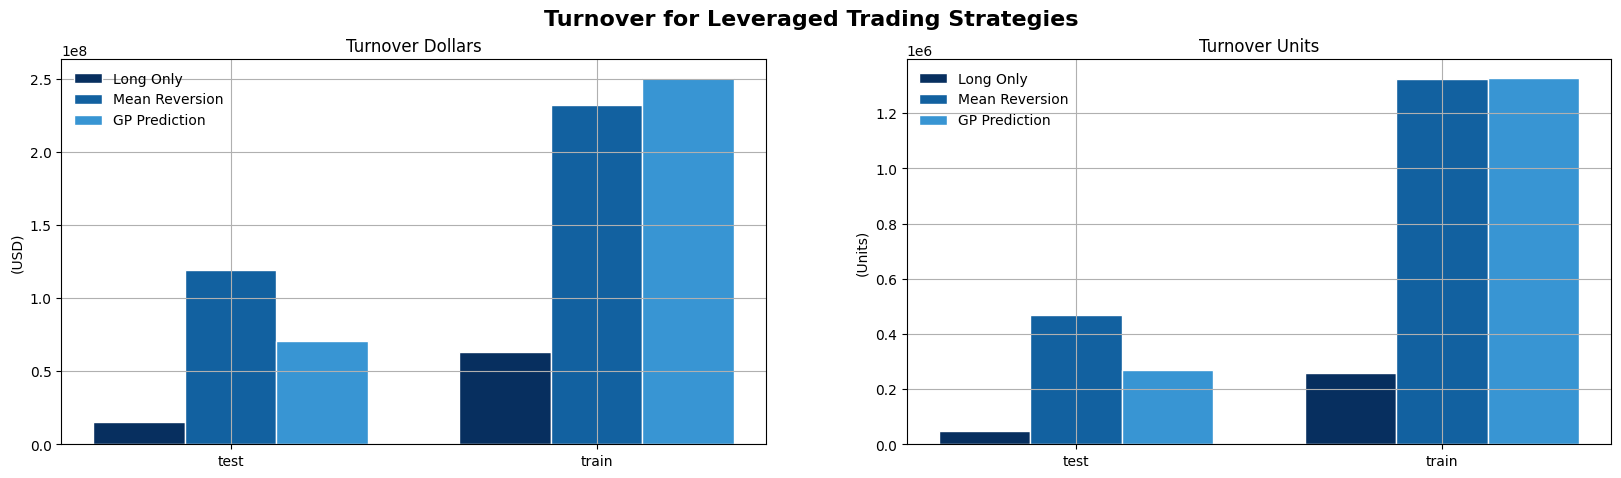

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=False)

barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(['test', 'train']))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
ax1.bar(br1, lo_turnover_dollars, color =palette[0], width = barWidth, edgecolor ='white', label ='Long Only')
ax1.bar(br2, gpmr_turnover_dollars, color =palette[1], width = barWidth, edgecolor ='white', label ='Mean Reversion')
ax1.bar(br3, gp_pred_turnover_dollars, color =palette[2], width = barWidth, edgecolor ='white', label ='GP Prediction')
ax1.set_title('Turnover Dollars')
ax1.set_ylabel('(USD)')
ax1.grid(True)
ax1.legend(loc='upper left',frameon=False)
ax1.set_xticks([r + barWidth for r in range(len(['train', 'test']))], ['test', 'train'])

ax2.bar(br1, lo_turnover_units, color =palette[0], width = barWidth, edgecolor ='white', label ='Long Only')
ax2.bar(br2, gpmr_turnover_units, color =palette[1], width = barWidth, edgecolor ='white', label ='Mean Reversion')
ax2.bar(br3, gp_pred_turnover_units, color =palette[2], width = barWidth, edgecolor ='white', label ='GP Prediction')
ax2.grid(True)
ax2.legend(loc='upper left',frameon=False)
ax2.set_title('Turnover Units')
ax2.set_ylabel('(Units)')
ax2.set_xticks([r + barWidth for r in range(len(['train', 'test']))], ['test', 'train'])


plt.suptitle('Turnover for Leveraged Trading Strategies', fontsize=16, fontweight='bold')

# save figure
plt.savefig('figures/05_turnover.png')

In [20]:
print(gp_pred_turnover_units)

[268941.4790540568, 1328879.028457047]


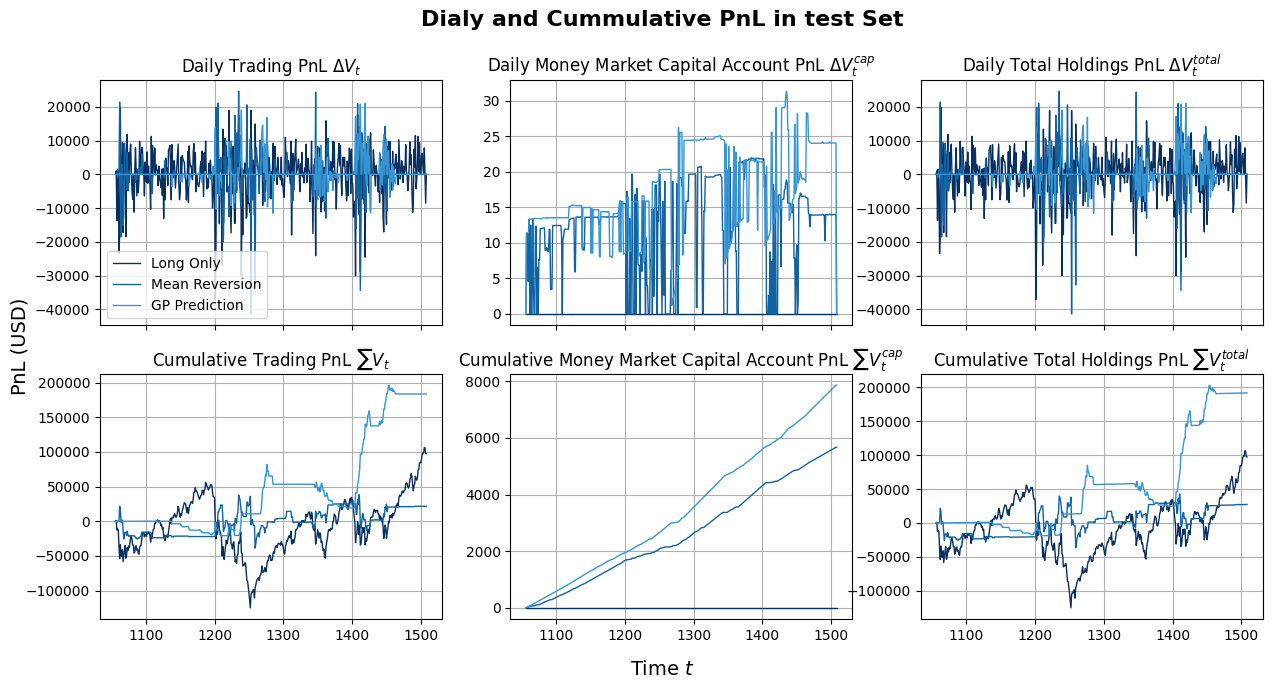

In [21]:
# training holdings
palette = ["#072F5F", "#1261A0", "#3895D3", "#58CCED"]


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=True, sharey = False, figsize = (15, 7))

ax1.plot(x_test, test_lo_strat['delta_V_t'], color = "#072F5F", lw = 1, alpha = 1, label ='Long Only')
ax1.plot(x_test, test_gpmr_strat['delta_V_t'], color = "#1261A0", lw = 1, alpha = 1, label ='Mean Reversion')
ax1.plot(x_test, test_gp_pred_strat['delta_V_t'], color = "#3895D3", lw = 1, alpha = 1, label ='GP Prediction')
ax1.set_title(r'Daily Trading PnL $\Delta V_t$')
ax1.grid(True)
ax1.legend(loc='lower left', frameon=True)

ax2.plot(x_test, test_lo_strat['delta_V_cap'], color = "#072F5F", lw = 1, alpha = 1, label ='Long Only')
ax2.plot(x_test, test_gpmr_strat['delta_V_cap'], color = "#1261A0", lw = 1, alpha = 1, label ='Mean Reversion')
ax2.plot(x_test, test_gp_pred_strat['delta_V_cap'], color = "#3895D3", lw = 1, alpha = 1, label ='GP Prediction')
ax2.set_title(r'Daily Money Market Capital Account PnL $\Delta V_t^{cap}$')
ax2.grid(True)

ax3.plot(x_test, test_lo_strat['delta_V_total'], color = "#072F5F", lw = 1, alpha = 1)
ax3.plot(x_test, test_gpmr_strat['delta_V_total'], color = "#1261A0", lw = 1, alpha = 1)
ax3.plot(x_test, test_gp_pred_strat['delta_V_total'], color = "#3895D3", lw = 1, alpha = 1)
ax3.set_title(r'Daily Total Holdings PnL $\Delta V_t^{total}$')
ax3.grid(True)

# CUMMULATIVE

ax4.plot(x_test, np.cumsum(test_lo_strat['delta_V_t']), color = "#072F5F", lw = 1, alpha = 1)
ax4.plot(x_test, np.cumsum(test_gpmr_strat['delta_V_t']), color = "#1261A0", lw = 1, alpha = 1)
ax4.plot(x_test, np.cumsum(test_gp_pred_strat['delta_V_t']), color = "#3895D3", lw = 1, alpha = 1)
ax4.set_title(r'Cumulative Trading PnL $\sum V_t$')
ax4.grid(True)

ax5.plot(x_test, np.cumsum(test_lo_strat['delta_V_cap']), color = "#072F5F", lw = 1, alpha = 1)
ax5.plot(x_test, np.cumsum(test_gpmr_strat['delta_V_cap']), color = "#1261A0", lw = 1, alpha = 1)
ax5.plot(x_test, np.cumsum(test_gp_pred_strat['delta_V_cap']), color = "#3895D3", lw = 1, alpha = 1)
ax5.set_title(r'Cumulative Money Market Capital Account PnL $\sum V_t^{cap}$')
ax5.grid(True)


ax6.plot(x_test, np.cumsum(test_lo_strat['delta_V_total']), color = "#072F5F", lw = 1, alpha = 1)
ax6.plot(x_test, np.cumsum(test_gpmr_strat['delta_V_total']), color = "#1261A0", lw = 1, alpha = 1)
ax6.plot(x_test, np.cumsum(test_gp_pred_strat['delta_V_total']), color = "#3895D3", lw = 1, alpha = 1)
ax6.set_title(r'Cumulative Total Holdings PnL $\sum V_t^{total}$')
ax6.grid(True)

plt.suptitle('Dialy and Cummulative PnL in test Set', fontsize=16, fontweight='bold')

fig.text(0.5, 0.03, r'Time $t$', ha='center', fontsize=14)
fig.text(0.065, 0.5, 'PnL (USD)', va='center', rotation='vertical', fontsize=14)

plt.savefig('figures/06_pnl.png')

# Performance Indicators

In [22]:
def sharpe_ratio(
        excess_returns : np.ndarray,
        ) -> float:
    """
    Calculates the sharpe ratio of a strategy

    Arguments:
    ----------
        excess_returns      : {np.ndarray}
                                > The excess returns of a strategy
                                (already discounted by the risk-free rate)
        
    Returns:
    ----------
        sharpe_ratio        : {float}
                                > The sharpe ratio of a strategy
    """
 
    # computes the sharpe ratio
    # sharpies = np.sum(excess_returns) / (np.std(excess_returns) * np.sqrt(len(excess_returns)))

    sharpies = ((np.mean(excess_returns * 252)) / (np.std(excess_returns)*np.sqrt(252)))
    
    return sharpies 

In [23]:
def sortino_ratio( 
        excess_returns : np.ndarray,
        ) -> float:
    """
    Calculates the sortino ratio of a strategy

    Arguments:
    ----------
        excess_returns      : {np.ndarray}
                                > The excess returns of a strategy
                                (already discounted by the risk-free rate)

    Returns:
    ----------
        sortino_ratio       : {float}
                                > The sortino ratio of a strategy
    """
    # computes the sortino ratio
    # sorties = np.sum(excess_returns) / (np.std(excess_returns[excess_returns < 0]) * np.sqrt(len(excess_returns)))

    sorties = ((np.mean(excess_returns*252)) / (np.std(excess_returns[excess_returns < 0])*np.sqrt(252)))

    return sorties

In [24]:
test_lo_excess_returns = test_lo_strat['delta_V_total'][1:] / test_lo_strat['V_total'][:-1]
test_gpmr_excess_returns = test_gpmr_strat['delta_V_total'][1:] / test_gpmr_strat['V_total'][:-1]
test_gp_pred_excess_returns = test_gp_pred_strat['delta_V_total'][1:] / test_gp_pred_strat['V_total'][:-1]

train_lo_excess_returns = train_lo_strat['delta_V_total'][1:] / train_lo_strat['V_total'][:-1]
train_gpmr_excess_returns = train_gpmr_strat['delta_V_total'][1:] / train_gpmr_strat['V_total'][:-1]
train_gp_pred_excess_returns = train_gp_pred_strat['delta_V_total'][1:] / train_gp_pred_strat['V_total'][:-1]

In [25]:
# SHARPIES - TEST

TEST_sharpe_lo = sharpe_ratio(test_lo_excess_returns)
TEST_sharpe_gpmr = sharpe_ratio(test_gpmr_excess_returns)
TEST_sharpe_gp_pred = sharpe_ratio(test_gp_pred_excess_returns)

# SHARPIES - TRAIN
TRAIN_sharpe_lo = sharpe_ratio(train_lo_excess_returns)
TRAIN_sharpe_gpmr = sharpe_ratio(train_gpmr_excess_returns)
TRAIN_sharpe_gp_pred = sharpe_ratio(train_gp_pred_excess_returns)

# set height of bar
lo_SHARPE = [TEST_sharpe_lo, TRAIN_sharpe_lo]
mr_SHAPRE = [TEST_sharpe_gpmr, TRAIN_sharpe_gpmr]
pred_SHAPRE = [TEST_sharpe_gp_pred, TRAIN_sharpe_gp_pred]



print('TEST Sharpe Ratio for Long Only Strategy: {}'.format(TEST_sharpe_lo))
print('TEST Sharpe Ratio for Mean Reversion Strategy: {}'.format(TEST_sharpe_gpmr))
print('TEST Sharpe Ratio for GP Prediction Strategy: {}'.format(TEST_sharpe_gp_pred))
print()
print('TRAIN Sharpe Ratio for Long Only Strategy: {}'.format(TRAIN_sharpe_lo))
print('TRAIN Sharpe Ratio for Mean Reversion Strategy: {}'.format(TRAIN_sharpe_gpmr))
print('TRAIN Sharpe Ratio for GP Prediction Strategy: {}'.format(TRAIN_sharpe_gp_pred))

TEST Sharpe Ratio for Long Only Strategy: 0.672301599454528
TEST Sharpe Ratio for Mean Reversion Strategy: 0.38312528689429637
TEST Sharpe Ratio for GP Prediction Strategy: 1.804934042439307

TRAIN Sharpe Ratio for Long Only Strategy: 0.9755308185447582
TRAIN Sharpe Ratio for Mean Reversion Strategy: 0.11072330741839159
TRAIN Sharpe Ratio for GP Prediction Strategy: 0.7511059100807413


In [26]:
# SORTIES - TEST
TEST_sortino_lo = sortino_ratio(test_lo_excess_returns)
TEST_sortino_gpmr = sortino_ratio(test_gpmr_excess_returns)
TEST_sortino_gp_pred = sortino_ratio(test_gp_pred_excess_returns)

# SORTIES - TRAIN
TRAIN_sortino_lo = sortino_ratio(train_lo_excess_returns)
TRAIN_sortino_gpmr = sortino_ratio(train_gpmr_excess_returns)
TRAIN_sortino_gp_pred = sortino_ratio(train_gp_pred_excess_returns)

# set height of bar
lo_SORTINO = [TEST_sortino_lo, TRAIN_sortino_lo]
mr_SORTINO = [TEST_sortino_gpmr, TRAIN_sortino_gpmr]
pred_SORTINO = [TEST_sortino_gp_pred, TRAIN_sortino_gp_pred]


print('TEST Sortino Ratio for Long Only Strategy: {}'.format(TEST_sortino_lo))
print('TEST Sortino Ratio for Mean Reversion Strategy: {}'.format(TEST_sortino_gpmr))
print('TEST Sortino Ratio for GP Prediction Strategy: {}'.format(TEST_sortino_gp_pred))

print()

print('TRAIN Sortino Ratio for Long Only Strategy: {}'.format(TRAIN_sortino_lo))
print('TRAIN Sortino Ratio for Mean Reversion Strategy: {}'.format(TRAIN_sortino_gpmr))
print('TRAIN Sortino Ratio for GP Prediction Strategy: {}'.format(TRAIN_sortino_gp_pred))


TEST Sortino Ratio for Long Only Strategy: 0.8347687906091366
TEST Sortino Ratio for Mean Reversion Strategy: 0.2888614965493818
TEST Sortino Ratio for GP Prediction Strategy: 1.9680219196480193

TRAIN Sortino Ratio for Long Only Strategy: 1.2180367386966113
TRAIN Sortino Ratio for Mean Reversion Strategy: 0.08652650569492593
TRAIN Sortino Ratio for GP Prediction Strategy: 0.9388824917328429


In [27]:
# DRAWIES - TEST
TEST_drawdown_lo = max_drawdown(test_lo_strat['delta_V_total'][:-1], test_lo_strat['V_total'][:-1])
TEST_drawdown_gpmr = max_drawdown(test_gpmr_strat['delta_V_total'][:-1], test_gpmr_strat['V_total'][:-1])
TEST_drawdown_gp_pred = max_drawdown(test_gp_pred_strat['delta_V_total'][:-1], test_gp_pred_strat['V_total'][:-1])

# DRAWIES - TRAIN
TRAIN_drawdown_lo = max_drawdown(train_lo_strat['delta_V_total'][:-1], train_lo_strat['V_total'][:-1])
TRAIN_drawdown_gpmr = max_drawdown(train_gpmr_strat['delta_V_total'][:-1], train_gpmr_strat['V_total'][:-1])
TRAIN_drawdown_gp_pred = max_drawdown(train_gp_pred_strat['delta_V_total'][:-1], train_gp_pred_strat['V_total'][:-1])

# set height of bar
lo_DRAWDOWN = [TEST_drawdown_lo, TRAIN_drawdown_lo]
mr_DRAWDOWN = [TEST_drawdown_gpmr, TRAIN_drawdown_gpmr]
pred_DRAWDOWN = [TEST_drawdown_gp_pred, TRAIN_drawdown_gp_pred]

print('TEST Max Drawdown for Long Only Strategy: {}'.format(TEST_drawdown_lo))
print('TEST Max Drawdown for Mean Reversion Strategy: {}'.format(TEST_drawdown_gpmr))
print('TEST Max Drawdown for GP Prediction Strategy: {}'.format(TEST_drawdown_gp_pred))

print()

print('TRAIN Max Drawdown for Long Only Strategy: {}'.format(TRAIN_drawdown_lo))
print('TRAIN Max Drawdown for Mean Reversion Strategy: {}'.format(TRAIN_drawdown_gpmr))
print('TRAIN Max Drawdown for GP Prediction Strategy: {}'.format(TRAIN_drawdown_gp_pred))

TEST Max Drawdown for Long Only Strategy: -0.7907573407848392
TEST Max Drawdown for Mean Reversion Strategy: -0.40355234077813285
TEST Max Drawdown for GP Prediction Strategy: -0.22136333959442467

TRAIN Max Drawdown for Long Only Strategy: -0.8107005473394034
TRAIN Max Drawdown for Mean Reversion Strategy: -0.6452921828736087
TRAIN Max Drawdown for GP Prediction Strategy: -0.5011844103995974


In [28]:
# CALMIES - TEST
TEST_calmar_lo = calmar_ratio(test_lo_strat['delta_V_total'][:-1], test_lo_strat['V_total'][:-1])
TEST_calmar_gpmr = calmar_ratio(test_gpmr_strat['delta_V_total'][:-1], test_gpmr_strat['V_total'][:-1])
TEST_calmar_gp_pred = calmar_ratio(test_gp_pred_strat['delta_V_total'][:-1], test_gp_pred_strat['V_total'][:-1])

# CALMIES - TRAIN
TRAIN_calmar_lo = calmar_ratio(train_lo_strat['delta_V_total'][:-1], train_lo_strat['V_total'][:-1])
TRAIN_calmar_gpmr = calmar_ratio(train_gpmr_strat['delta_V_total'][:-1], train_gpmr_strat['V_total'][:-1])
TRAIN_calmar_gp_pred = calmar_ratio(train_gp_pred_strat['delta_V_total'][:-1], train_gp_pred_strat['V_total'][:-1])

# set height of bar
lo_CALMAR = [TEST_calmar_lo, TRAIN_calmar_lo]
mr_CALMAR = [TEST_calmar_gpmr, TRAIN_calmar_gpmr]
pred_CALMAR = [TEST_calmar_gp_pred, TRAIN_calmar_gp_pred]

print('TEST Calmar Ratio for Long Only Strategy: {}'.format(TEST_calmar_lo))
print('TEST Calmar Ratio for Mean Reversion Strategy: {}'.format(TEST_calmar_gpmr))
print('TEST Calmar Ratio for GP Prediction Strategy: {}'.format(TEST_calmar_gp_pred))

print()

print('TRAIN Calmar Ratio for Long Only Strategy: {}'.format(TRAIN_calmar_lo))
print('TRAIN Calmar Ratio for Mean Reversion Strategy: {}'.format(TRAIN_calmar_gpmr))
print('TRAIN Calmar Ratio for GP Prediction Strategy: {}'.format(TRAIN_calmar_gp_pred))

TEST Calmar Ratio for Long Only Strategy: -0.1106745272924282
TEST Calmar Ratio for Mean Reversion Strategy: -0.09257589729562266
TEST Calmar Ratio for GP Prediction Strategy: 2.842364332928861

TRAIN Calmar Ratio for Long Only Strategy: 1.0746918914293082
TRAIN Calmar Ratio for Mean Reversion Strategy: -0.5457921863402939
TRAIN Calmar Ratio for GP Prediction Strategy: 1.0746457588217935


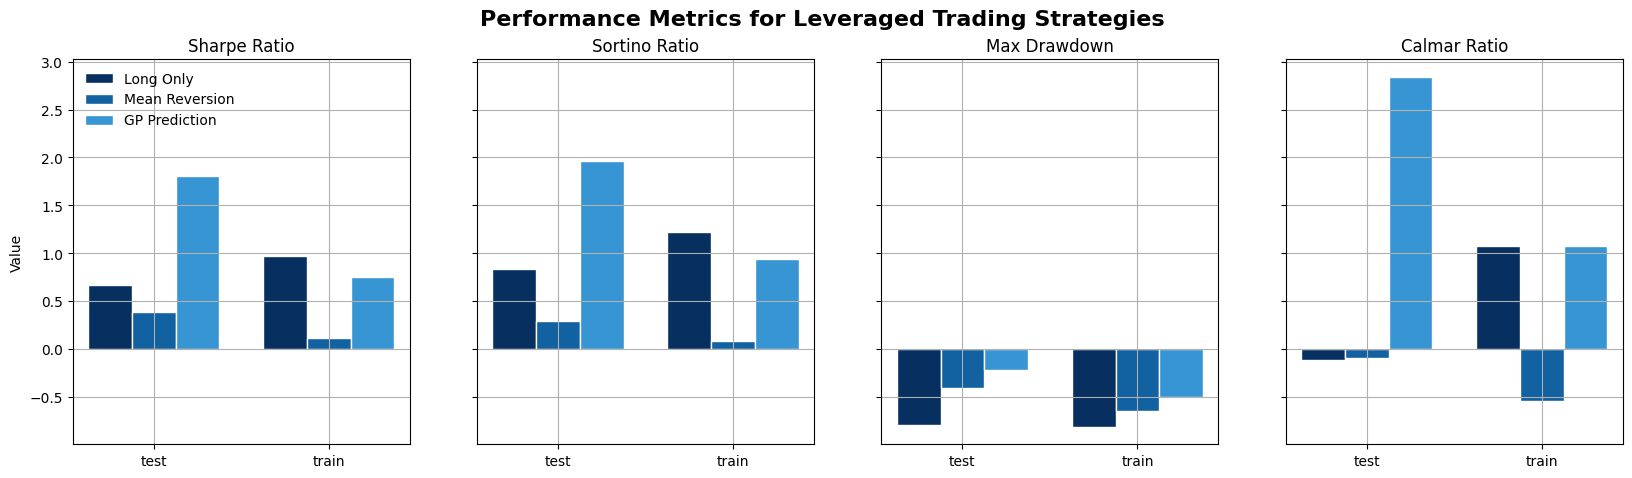

In [29]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(['train', 'test']))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
ax1.bar(br1, lo_SHARPE, color =palette[0], width = barWidth, edgecolor ='white', label ='Long Only')
ax1.bar(br2, mr_SHAPRE, color =palette[1], width = barWidth, edgecolor ='white', label ='Mean Reversion')
ax1.bar(br3, pred_SHAPRE, color =palette[2], width = barWidth, edgecolor ='white', label ='GP Prediction')
ax1.set_title('Sharpe Ratio')
ax1.set_ylabel('Value')
ax1.grid(True)
ax1.legend(loc='upper left',frameon=False)
ax1.set_xticks([r + barWidth for r in range(len(['train', 'test']))], ['test', 'train'])

ax2.bar(br1, lo_SORTINO, color =palette[0], width = barWidth, edgecolor ='white', label ='Long Only')
ax2.bar(br2, mr_SORTINO, color =palette[1], width = barWidth, edgecolor ='white', label ='Mean Reversion')
ax2.bar(br3, pred_SORTINO, color =palette[2], width = barWidth, edgecolor ='white', label ='GP Prediction')
ax2.grid(True)
# ax2.legend(loc='upper left',frameon=False)
ax2.set_title('Sortino Ratio')

ax3.bar(br1, lo_DRAWDOWN, color =palette[0], width = barWidth, edgecolor ='white', label ='Long Only')
ax3.bar(br2, mr_DRAWDOWN, color =palette[1], width = barWidth, edgecolor ='white', label ='Mean Reversion')
ax3.bar(br3, pred_DRAWDOWN, color =palette[2], width = barWidth, edgecolor ='white', label ='GP Prediction')
ax3.grid(True)
# ax3.legend(loc='upper left',frameon=False)
ax3.set_title('Max Drawdown')

ax4.bar(br1, lo_CALMAR, color =palette[0], width = barWidth, edgecolor ='white', label ='Long Only')
ax4.bar(br2, mr_CALMAR, color =palette[1], width = barWidth, edgecolor ='white', label ='Mean Reversion')
ax4.bar(br3, pred_CALMAR, color =palette[2], width = barWidth, edgecolor ='white', label ='GP Prediction')
ax4.grid(True)
# ax4.legend(loc='upper left',frameon=False)
ax4.set_title('Calmar Ratio')

plt.suptitle('Performance Metrics for Leveraged Trading Strategies', fontsize=16, fontweight='bold')

# save figure
plt.savefig('figures/07_performance_metrics.png')

In [30]:
p_returns = np.diff(p_test) / p_test[:-1]
annualised_returns =p_returns * 252
p_avg = annualised_returns.mean() * 100
p_std = p_returns.std() * np.sqrt(252) * 100

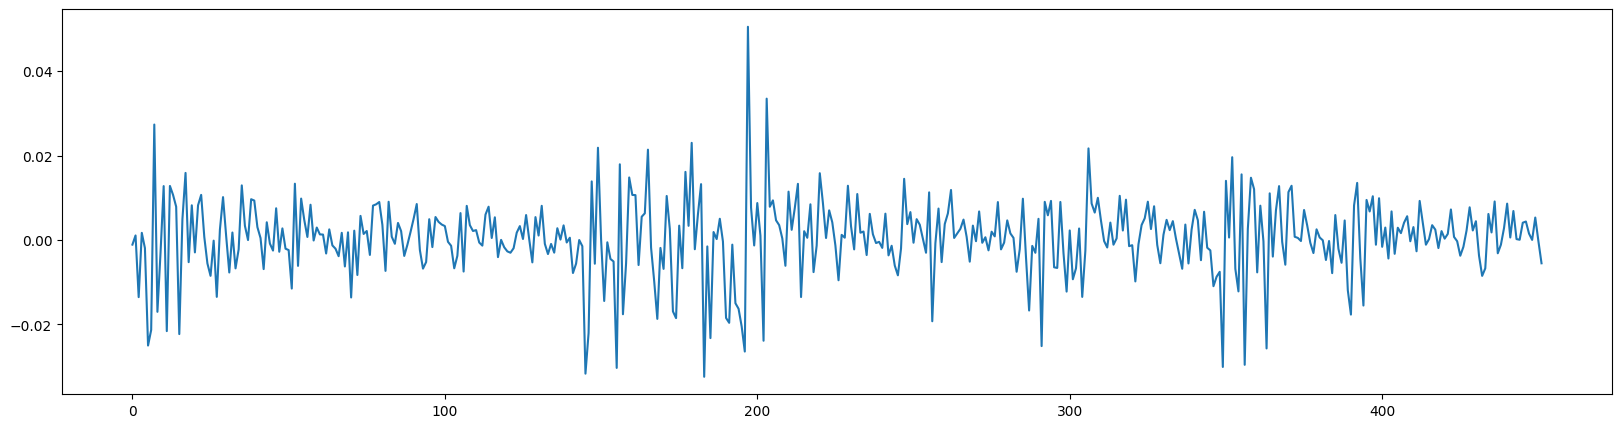

In [31]:
plt.plot(p_returns)

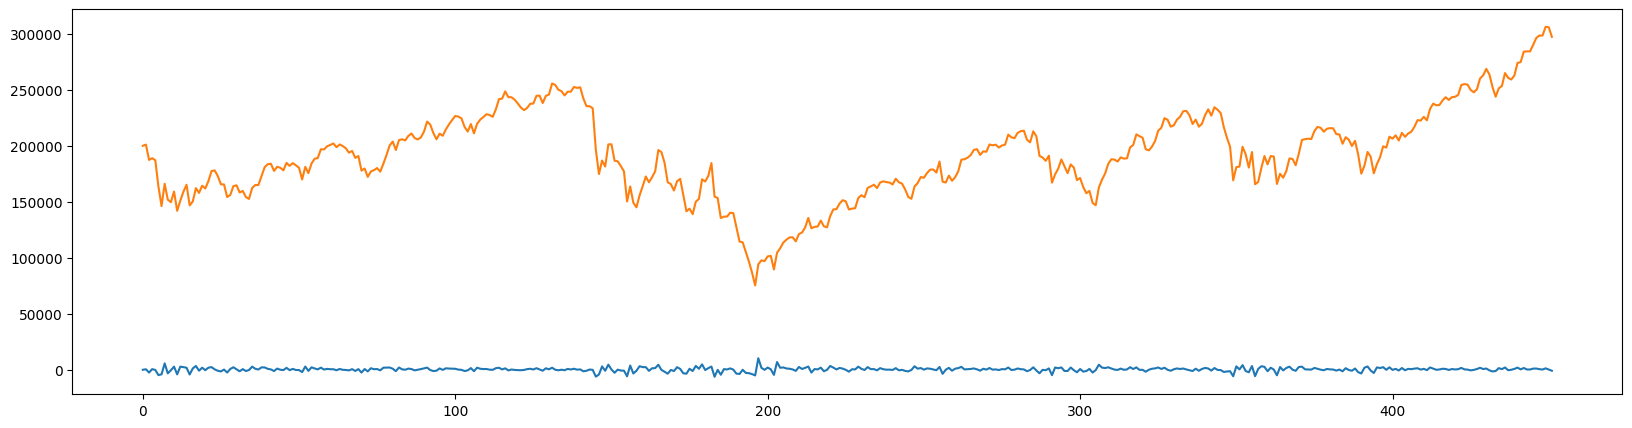

In [32]:
plt.plot(200_000 * p_returns)
plt.plot(test_lo_strat['V_total'][:-1])

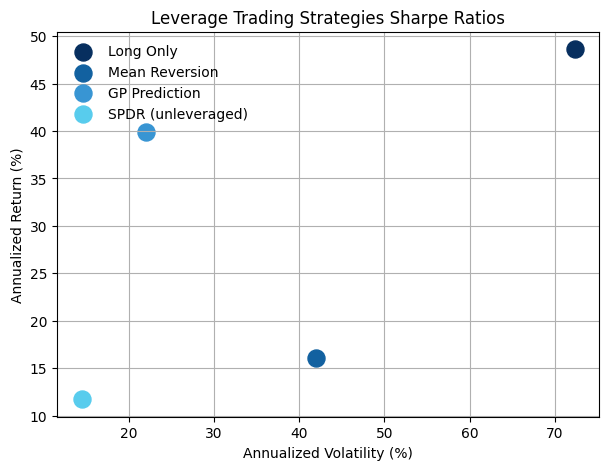

In [33]:


test_lo_delta_vt_avg = np.mean(test_lo_excess_returns*252)* 100
test_lo_delta_vt_std = np.std(test_lo_excess_returns)*np.sqrt(252) * 100

test_gpmr_delta_vt_avg = np.mean(test_gpmr_excess_returns*252)* 100
test_gpmr_delta_vt_std = np.std(test_gpmr_excess_returns)*np.sqrt(252) * 100

test_gp_pred_delta_vt_avg = np.mean(test_gp_pred_excess_returns*252)* 100
test_gp_pred_delta_vt_std = np.std(test_gp_pred_excess_returns)*np.sqrt(252) * 100

plt.figure(figsize=(7, 5))
plt.scatter(test_lo_delta_vt_std, test_lo_delta_vt_avg, color=palette[0], label='Long Only', s = 150)
plt.scatter(test_gpmr_delta_vt_std, test_gpmr_delta_vt_avg, color=palette[1], label='Mean Reversion', s = 150)
plt.scatter(test_gp_pred_delta_vt_std, test_gp_pred_delta_vt_avg, color=palette[2], label='GP Prediction', s = 150)
plt.scatter(p_std, p_avg, color=palette[3], label='SPDR (unleveraged)', s = 150)
plt.legend(loc='upper left',frameon=False)
plt.grid(True)
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Annualized Return (%)')
plt.title('Leverage Trading Strategies Sharpe Ratios')

# save figure
plt.savefig('figures/08_sharpe_ratios.png')

In [34]:
test_lo_excess_returns = test_lo_strat['delta_V_total'][1:] / test_lo_strat['V_total'][:-1]

In [35]:
len(test_lo_strat['V_total'])

453

In [36]:
len(test_gp_pred_strat['V_total'])

453

In [37]:
def objective_function(w1, w2):
    new_V_total = (w1*test_lo_strat['V_total']) + (w2*test_gp_pred_strat['V_total'])
    new_excess_returns = np.diff(new_V_total) / new_V_total[:-1]
    sharp = sharpe_ratio(new_excess_returns[:-1])
    if sharp == np.nan:
        return 0 
    return sharp

In [38]:
x = np.linspace(0, 1, 100)
y = 1 - x

X, Y = np.meshgrid(x, y)
XY = np.column_stack((X.ravel(), Y.ravel()))
XY /= np.sum(XY, axis=1).reshape(-1, 1)

X = XY[:, 0].reshape(X.shape)
Y = XY[:, 1].reshape(Y.shape)

/var/folders/bd/shyl3h_n5bq3xz2xw1yv1jnm0000gp/T/ipykernel_18980/755015850.py:6: RuntimeWarning: invalid value encountered in divide
  XY /= np.sum(XY, axis=1).reshape(-1, 1)


/var/folders/bd/shyl3h_n5bq3xz2xw1yv1jnm0000gp/T/ipykernel_18980/438766726.py:14: RuntimeWarning: invalid value encountered in divide
  XY /= np.sum(XY, axis=1).reshape(-1, 1)


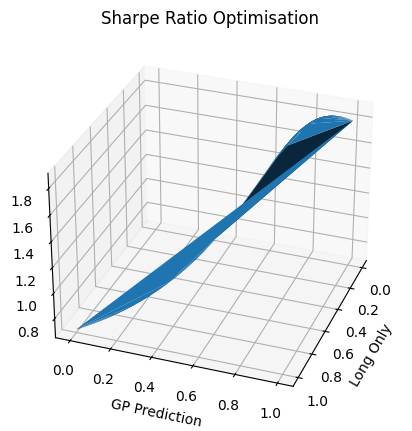

In [39]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure( figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')


x = np.linspace(0, 1, 100)
y = 1 - x

X, Y = np.meshgrid(x, y)
XY = np.column_stack((X.ravel(), Y.ravel()))
XY /= np.sum(XY, axis=1).reshape(-1, 1)

X = XY[:, 0].reshape(X.shape)
Y = XY[:, 1].reshape(Y.shape)

Z = np.zeros_like(X.ravel())

for i in range(len(X.ravel())):
    Z[i] = objective_function(X.ravel()[i], Y.ravel()[i])

Z = np.array(Z).reshape(X.shape)


ax.plot_surface(X, Y, Z)
ax.view_init(elev=30, azim=20)
ax.set_xlabel('Long Only')
ax.set_ylabel('GP Prediction')
ax.set_title('Sharpe Ratio Optimisation')

# save figure
plt.savefig('figures/09_portfolio_optimisation.png')

In [40]:
np.argmax(Z.ravel())

9900

In [41]:
np.isnan(X.ravel()).sum()

1

In [42]:
X.ravel()[9899]

0.9900000000000001

In [43]:
Y.ravel()[9899]

0.009999999999999957

In [44]:
def objective_function(w1, w2, w3):
    combo_mean = w1*test_lo_delta_vt_avg + w2*test_gpmr_delta_vt_avg + w3*test_gp_pred_delta_vt_avg
    combo_std = w1*test_lo_delta_vt_std + w2*test_gpmr_delta_vt_std + w3*test_gp_pred_delta_vt_std
    return combo_mean / combo_std

In [45]:
import numpy as np


# Define two arrays with 39 values that sum to 1
x = np.random.rand(10000)
y = np.random.rand(10000)

# Calculate the third array from their difference
z = 1 - np.clip(x - y, 0, 1)

# Add the last value of 1 to each array
x = np.append(x, 1)
y = np.append(y, 1)
z = np.append(z, 1)

output = objective_function(x, y, z)


In [46]:
idx_max_combo = np.argmax(output)
max_sharpe = output[idx_max_combo]

max_x = x[idx_max_combo]
max_y = y[idx_max_combo]
max_z = z[idx_max_combo]

print('Max Combo: ', max_x, max_y, max_z)
print()
print('Sharpe Ratio: ', max_sharpe)
print('Long Oonly Sharpe Ratio: ', test_lo_delta_vt_avg / test_lo_delta_vt_std)
print('GP pred Sharpe Ratio: ', test_gp_pred_delta_vt_avg / test_gp_pred_delta_vt_std)

Max Combo:  0.00017578657245553853 0.003221871387566244 1.0

Sharpe Ratio:  1.7956226309959267
Long Oonly Sharpe Ratio:  0.6723015994545279
GP pred Sharpe Ratio:  1.8049340424393068


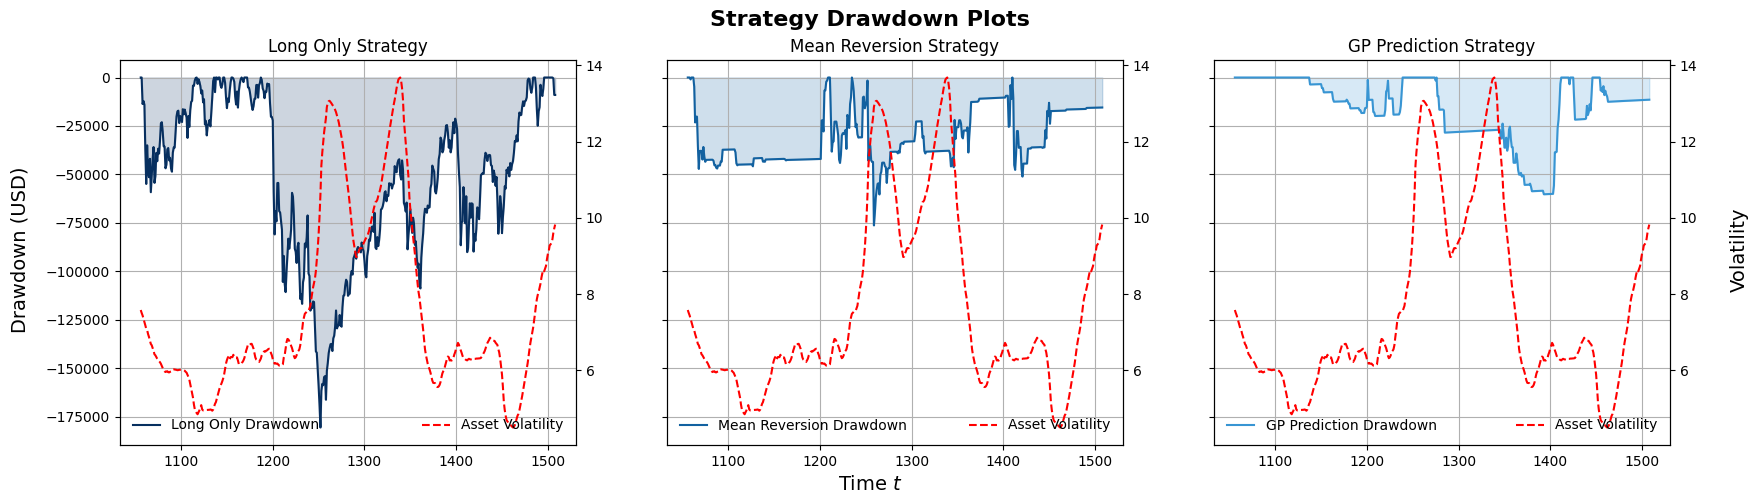

In [47]:
original_price = torch.cat((p_train, p_test), dim=0)
original_price_volatility = original_price.unfold(0, 90, 1).std(dim=1)[-len(p_test):]

lo_PNL = np.cumsum(test_lo_strat['delta_V_total'])
lo_DRAWDOWN =  lo_PNL - np.maximum.accumulate(lo_PNL)

mr_PNL = np.cumsum(test_gpmr_strat['delta_V_total'])
mr_DRAWDOWN =  mr_PNL - np.maximum.accumulate(mr_PNL)

pred_PNL = np.cumsum(test_gp_pred_strat['delta_V_total'])
pred_DRAWDOWN =  pred_PNL - np.maximum.accumulate(pred_PNL)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

ax1.plot(x_test, lo_DRAWDOWN, color=palette[0], label='Long Only Drawdown')

ax1_vol = ax1.twinx()
ax1_vol.plot(x_test, original_price_volatility, color='red', linestyle='dashed', label='Asset Volatility')
ax1_vol.legend(loc='lower right',frameon=False)

ax1.fill_between(x_test, lo_DRAWDOWN, color=palette[0], alpha=0.2)
ax1.grid(True)
ax1.legend(loc='lower left',frameon=False)

ax1.set_title('Long Only Strategy')


ax2.plot(x_test, mr_DRAWDOWN, color=palette[1], label='Mean Reversion Drawdown')

ax2_vol = ax2.twinx()
ax2_vol.plot(x_test, original_price_volatility, color='red', linestyle='dashed', label='Asset Volatility')
ax2_vol.legend(loc='lower right', frameon=False)

ax2.fill_between(x_test, mr_DRAWDOWN, color=palette[1], alpha=0.2)
ax2.grid(True)
ax2.legend(loc='lower left',frameon=False)

ax2.set_title('Mean Reversion Strategy')

ax3.plot(x_test, pred_DRAWDOWN, color=palette[2], label='GP Prediction Drawdown')

ax3_vol = ax3.twinx()
ax3_vol.plot(x_test, original_price_volatility, color='red', linestyle='dashed', label='Asset Volatility')
ax3_vol.legend(loc='lower right',frameon=False)

ax3.fill_between(x_test, pred_DRAWDOWN, color=palette[2], alpha=0.2)
ax3.grid(True)
ax3.legend(loc='lower left',frameon=False)

ax3.set_title('GP Prediction Strategy')

plt.suptitle('Strategy Drawdown Plots', fontsize=16, fontweight='bold')
fig.text(0.5, 0.02, r'Time $t$', ha='center', fontsize=14)
fig.text(0.07, 0.5, 'Drawdown (USD)', va='center', rotation='vertical', fontsize=14)
fig.text(0.93, 0.5, 'Volatility', va='center', rotation='vertical', fontsize=14)

# save figure
plt.savefig('figures/09_drawdown.png')

In [48]:
len(lo_DRAWDOWN)

453

In [49]:
# Create a pandas DataFrame from the two time series
df = pd.DataFrame({'lo_DRAWDOWN': lo_DRAWDOWN, 'original_price_volatility': original_price_volatility})

# Compute the rolling Pearson correlation coefficient
rolling_correlation = df.rolling(window=90).corr().iloc[:,0].dropna()

In [50]:
lo_corr = [corr for corr in rolling_correlation.values]

In [51]:
# Create a pandas DataFrame from the two time series
df = pd.DataFrame({'lo_DRAWDOWN': pred_DRAWDOWN, 'original_price_volatility': original_price_volatility})

# Compute the rolling Pearson correlation coefficient
K = df.rolling(window=90).corr().iloc[:,0].dropna()

In [52]:
gp_corr = [corr for corr in K.values]

In [53]:
(len(x_test) - 90)*2

726

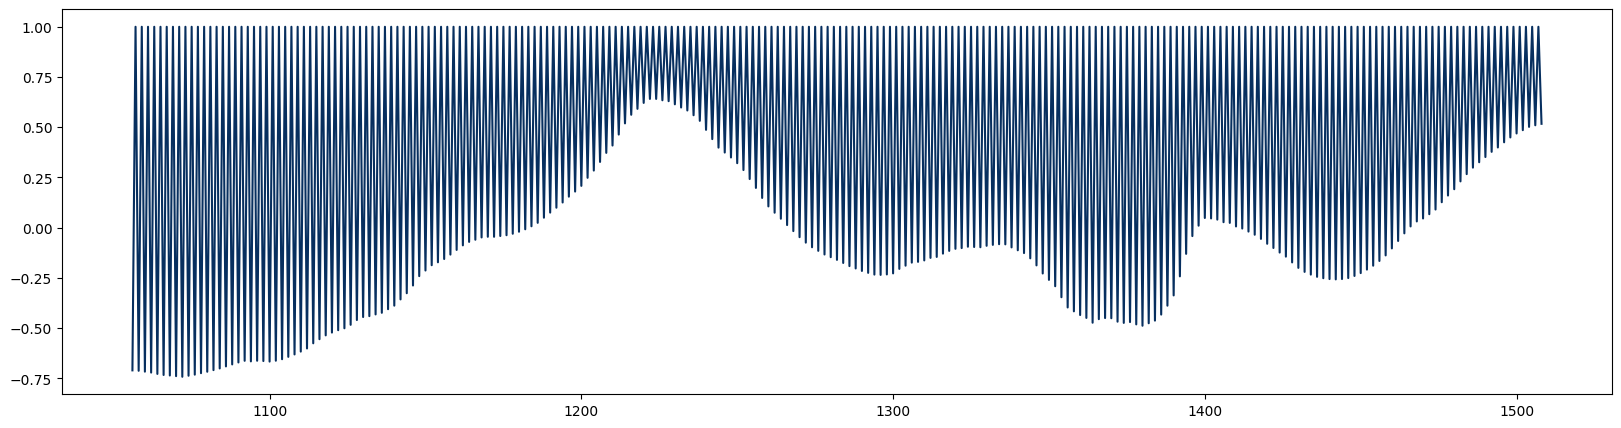

In [54]:
plt.plot(x_test, lo_corr[-len(x_test):], color=palette[0], label='Long Only Drawdown')

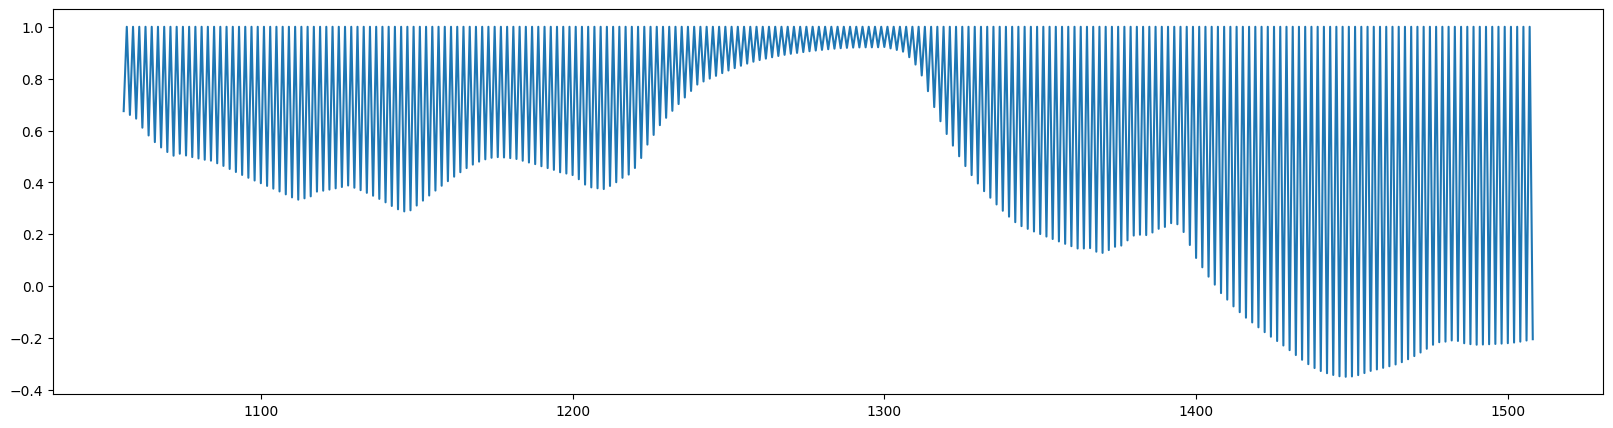

In [55]:
plt.plot(x_test, gp_corr[-len(x_test):])

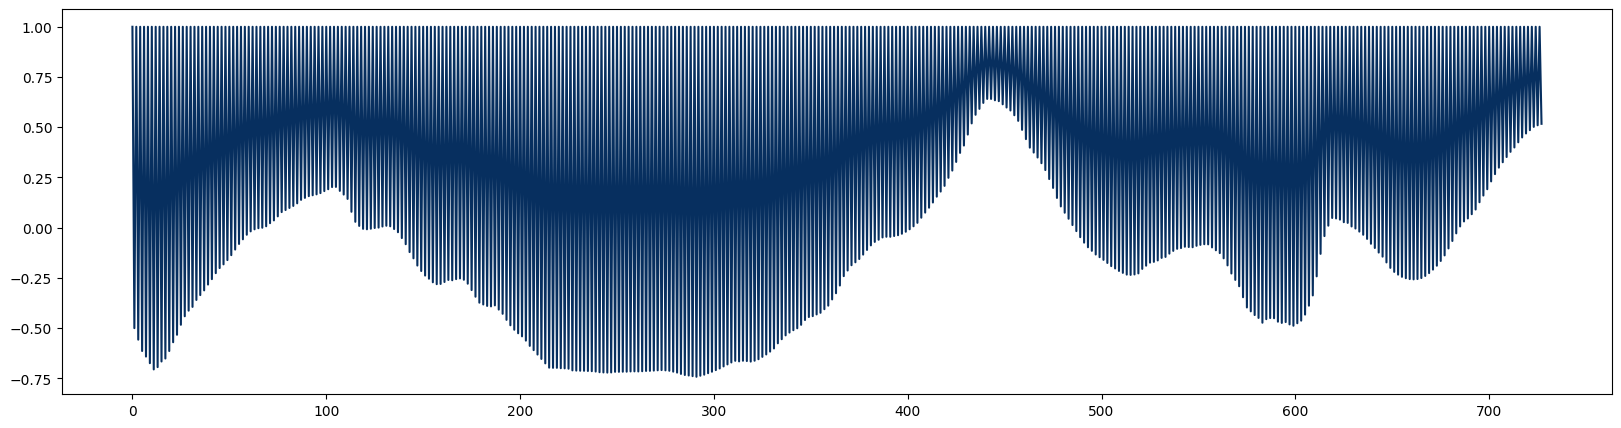

In [56]:
plt.plot(np.array(rolling_correlation.values), color=palette[0], label='Long Only Drawdown')

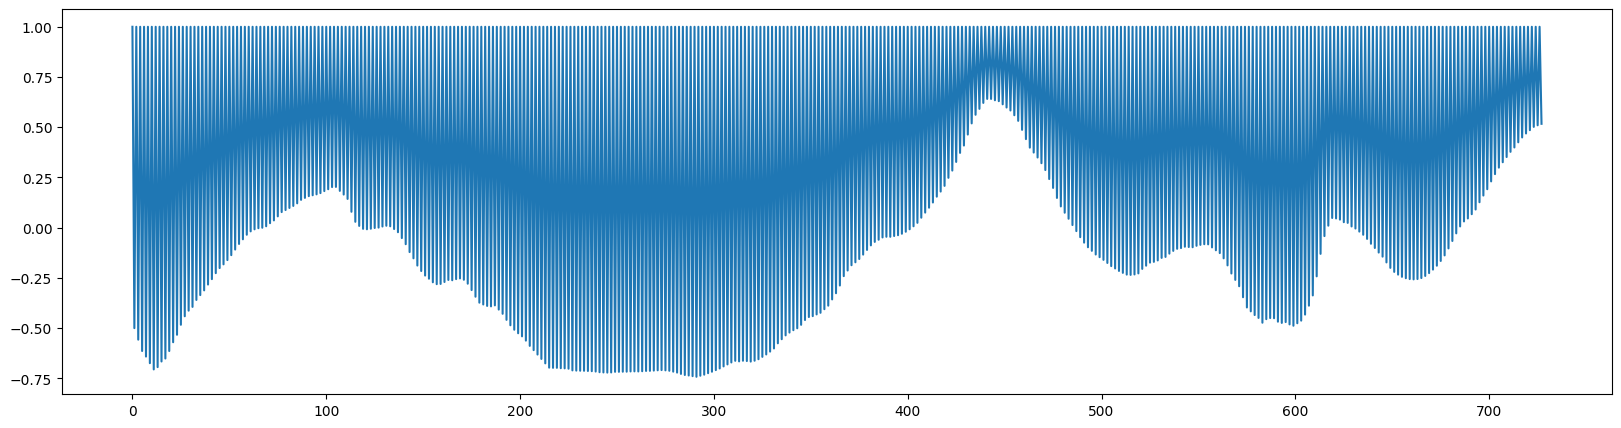

In [57]:
plt.plot(rolling_correlation.values)

In [58]:
def max_drawdown(returns):
    """
    Computes the maximum drawdown of a series of returns.

    Args:
        returns (np.ndarray): Array of returns

    Returns:
        float: Maximum drawdown
    """
    cum_returns = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (peak - cum_returns) / peak
    return np.max(drawdown)